# Functional impact

In this tutorial, we will use the summary data from gnomAD for MNV, and also for the constraint the are discussed in the main [flagship paper](https://www.biorxiv.org/content/10.1101/531210v2) of gnomAD, to evaluate the functional impact of MNV in population level.

Although this section is done using hail and hadoop, none of the work are actually using cloud computation. We can reproduce these results in local directory using pandas and by downloading publicly available gnomAD files.

(Also, the word "PTV" is often used in this tutorial, but in this tutorial it is equivalent to "nonsense", since we are not looking at splice variants or frameshifts.)

## Load the MNV data

31510 MNVs (transcripts) can be loaded into a single dataframe:

In [1]:
#loading the summary data of MNV from 125748 exomes in gnomAD dataset
import hail as hl
import hail.expr.aggregators as agg
from typing import *
import pandas as pd
ex = "gs://gnomad-public/release/2.1/mnv/gnomad_mnv_coding.tsv"
with hl.hadoop_open(ex, 'r') as f:
        mnv = pd.read_table(f)


Initializing Spark and Hail with default parameters...
Running on Apache Spark version 2.2.3
SparkUI available at http://10.128.0.8:4042
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.11-9b150225332b
LOGGING: writing to /home/hail/hail-20190311-0125-0.2.11-9b150225332b.log
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
mnv = mnv[mnv.AC_mnv_ex>0] #filtering to exomes (=throwing away those MNVs observed only in coding region of gnomAD genome data)
display(mnv.head())
print (mnv.shape)

,locus.position,locus.contig,transcript_id,categ,snp1,snp2,mnv,snp1_consequence,snp2_consequence,mnv_consequence,...,AC_snp2_ex,AC_snp2_gen,filter_snp1_ex,filter_snp1_gen,filter_snp2_ex,filter_snp2_gen,AN_snp1_ex,AN_snp1_gen,AN_snp2_ex,AN_snp2_gen
0,100203693,1,ENST00000287474,Unchanged,1-100203693-G-A,1-100203694-C-T,1-100203693-GC-AT,synonymous_variant,missense_variant,missense_variant,...,3,0,[],[],[],NaN,251098.0,31298.0,251342.0,NaN
1,100212983,1,ENST00000287474,Changed missense,1-100212983-G-A,1-100212984-T-A,1-100212983-GT-AA,missense_variant,missense_variant,missense_variant,...,1,0,[],NaN,[],NaN,243636.0,NaN,243050.0,NaN
3,100527429,1,ENST00000370152,Changed missense,1-100527429-C-A,1-100527430-A-T,1-100527429-CA-AT,missense_variant,synonymous_variant,missense_variant,...,1,0,[],NaN,[],NaN,250888.0,NaN,251016.0,NaN
4,100542778,1,ENST00000370152,Changed missense,1-100542778-G-A,1-100542779-G-T,1-100542778-GG-AT,missense_variant,missense_variant,missense_variant,...,1,0,[],NaN,[],NaN,247198.0,NaN,248258.0,NaN
5,100587079,1,ENST00000287482,Changed missense,1-100587079-G-A,1-100587080-C-A,1-100587079-GC-AA,missense_variant,missense_variant,missense_variant,...,2,0,[],NaN,[],NaN,241392.0,NaN,240648.0,NaN


(31510, 42)


## Calculate the number per functional category

(Reproducing figure 2a and 2b)

In [3]:
print (mnv.categ.value_counts())

Changed missense              14064
Unchanged                     12796
Partially changed missense     2193
Rescued nonsense               1818
Gained nonsense                 405
Lost missense                   160
Gained missense                  72
Rescued stop loss                 1
gained_stop_loss                  1
Name: categ, dtype: int64


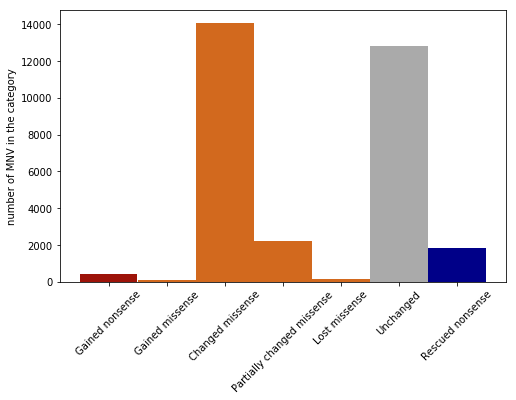

In [5]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
#let's plot it (figure 2a)
nums = mnv.categ.value_counts()[["Gained nonsense","Gained missense","Changed missense",
                                  "Partially changed missense","Lost missense",
                                  "Unchanged","Rescued nonsense"]] #ordering. Also, forget about stop loss -- there are only 2 there.
plt.figure(figsize=(8,5))
width = 0.99
plt.bar([1,2,3,4,5,6,7], nums, width, color=["#9D1309FF"]+["#D2691Eff"]*4+["#aaaaaaff"]+["#000088ff"])
plt.xticks([1,2,3,4,5,6,7], np.array(nums.index), rotation=45)
plt.ylabel("number of MNV in the category")
plt.show()

Also in the paper, we classified rescued nonsense in two different classes:

1. fully rescued nonsense: all the individuals carrying the nonsense is rescued (i.e. the nonsense indeed does not exist)
2. partially rescued nonsense: the nonsense is rescued in some individuals but not all (i.e. the nonsense still exists)

This classification can be done by comparing the allele count:

In [6]:
#get the number of perfect rescue (Fig 2a)
def get_ac_of_ptv(l):
    if l["snp1_consequence"]=="stop_gained": return l["AC_snp1_ex"]
    elif l["snp2_consequence"]=="stop_gained": return l["AC_snp2_ex"]
    else: return (-1) #indicator of error
rescued_PTV_candidate = mnv[mnv.categ=="Rescued nonsense"]
rescued_PTV_candidate["AC_of_PTV"] = rescued_PTV_candidate.apply(lambda l: get_ac_of_ptv(l), axis=1)
rescued_PTV_candidate["real_rescued_PTV"] = (rescued_PTV_candidate.AC_of_PTV==rescued_PTV_candidate.AC_mnv_ex)
rescued_PTV_candidate["real_rescued_PTV"].value_counts()
rescued_PTV_candidate[rescued_PTV_candidate["real_rescued_PTV"]]["transcript_id"].value_counts()
rescued_PTV_candidate[rescued_PTV_candidate["real_rescued_PTV"]]["transcript_id"].value_counts().value_counts()
real = rescued_PTV_candidate[rescued_PTV_candidate["real_rescued_PTV"]]

print ("out of {0}, {1} are perfectly rescued nonsenses".format(rescued_PTV_candidate.shape[0],real.shape[0]))

out of 1818, 1532 are perfectly rescued nonsenses


/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## per gene statistics

We can count how many gained/rescued nonsense there is for each gene (canonical transcript)

In [7]:
num_per_gene_rescue = real.transcript_id.value_counts().value_counts() #restricting to perfect rescue
num_per_gene_gain = mnv[mnv.categ=="Gained PTV"].transcript_id.value_counts().value_counts()
print (num_per_gene_gain)
print (num_per_gene_rescue)


Series([], Name: transcript_id, dtype: int64)
1    1276
2     106
3       8
4       2
7       1
5       1
Name: transcript_id, dtype: int64


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Microsoft Sans Serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Microsoft Sans Serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Microsoft Sans Serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


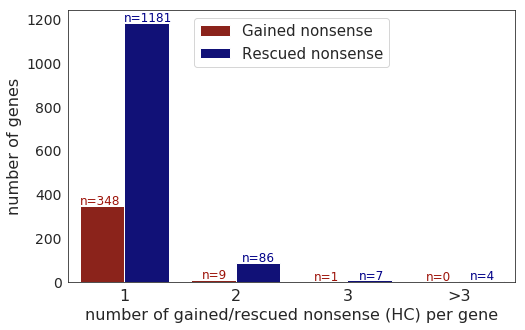

In [8]:
#based on this, make a plot (fig 2b)
#some manual work
import seaborn as sns
df = pd.DataFrame({"number":[1,2,3,4]*2,"PTV":[348,9,1,0]+[1181,86,7,4],"gained":["Gained nonsense"]*4+["Rescued nonsense"]*4})
sns.set_style("white")
sns.set_style({'axes.grid' : False})
plt.figure(figsize=(8,5))
sns.barplot(x="number", y="PTV", hue="gained",data=df, palette=["#9D1309FF","#000088ff"])
plt.legend(loc="upper center",prop={'family':"Microsoft Sans Serif", "size":15})
plt.xticks([0,1,2,3],["1","2","3",">3"],fontname="Microsoft Sans Serif", size=16)
plt.yticks(fontname = "Microsoft Sans Serif", size=14)
plt.ylabel("number of genes", fontname="Microsoft Sans Serif", size=16)
plt.xlabel("number of gained/rescued nonsense (HC) per gene", fontname="Microsoft Sans Serif", size=16)

#add "n="
for i in range(4):
    if i==0:
        plt.text(x=i - 0.4, y=df.PTV[i] + 6, s="n={0}".format(df.PTV[i]), size=12, color="#9D1309FF")
    else:
        plt.text(x = i-0.3 , y = df.PTV[i]+6, s = "n={0}".format(df.PTV[i]), size = 12, color="#9D1309FF")
for i in range(4):
    if i==0:
        plt.text(x=i, y=df.PTV[i + 4] + 6, s="n={0}".format(df.PTV[i + 4]), size=12, color="#000088ff")
    elif i==1:
        plt.text(x=i+0.05, y=df.PTV[i + 4] + 6, s="n={0}".format(df.PTV[i + 4]), size=12, color="#000088ff")
    else:
        plt.text(x = i+0.1 , y = df.PTV[i+4]+6, s = "n={0}".format(df.PTV[i+4]), size = 12, color="#000088ff")
plt.show()


We can also inspect the genes carrying high number of rescued/gained nonsense:

In [46]:
#checking those genes with high numbers (fig2b, boxes)
high_gain = real.transcript_id.value_counts().head(10)
high_rescue = mnv[mnv.categ=="Gained PTV"].transcript_id.value_counts().head(10)
print (high_gain)
print (high_rescue)

ENST00000368799    7
ENST00000389722    5
ENST00000589042    4
ENST00000262319    4
ENST00000343736    3
ENST00000435803    3
ENST00000536621    3
ENST00000307142    3
ENST00000354624    3
ENST00000335473    3
Name: transcript_id, dtype: int64
ENST00000368799    3
ENST00000570156    2
ENST00000445355    2
ENST00000281701    2
ENST00000360004    2
ENST00000418931    2
ENST00000376228    2
ENST00000358544    2
ENST00000368801    2
ENST00000410061    2
Name: transcript_id, dtype: int64


## Further inspection to the genes with >1 gained/rescued nonsense

Let's take a look at their gene name, and also see how many of these genes are reported to be relevant to disease. 

WE will first load a list of haploinsufficient / dominant genes curated from publicly available resource:
([Blekhman 2008](https://www.ncbi.nlm.nih.gov/pubmed/18571414), [Berg 2013](https://www.ncbi.nlm.nih.gov/pubmed/22995991) and [Clingen](https://www.ncbi.nlm.nih.gov/pubmed/26014595/))


In [11]:
with hl.hadoop_open("gs://gnomad-qingbowang/MNV/haploinsuff_trid.tsv", 'r') as f:
        hap = pd.read_table(f)
with hl.hadoop_open("gs://gnomad-qingbowang/MNV/dominant_trid.tsv", 'r') as f:
        dom = pd.read_table(f)
#cleaning
hap = hap["Unnamed: 1"]
hap.fillna("na",inplace=True)
dom = dom["Unnamed: 1"]
dom.fillna("na",inplace=True)
print (hap.shape)
display(hap.head())
print (dom.shape)
display(dom.head())

#since we are interested in both in same way, we will merge this
hap_or_dom = np.union1d(hap.astype(str), dom.astype(str)) #genes that are haploinsufficient or dominant
print (len(hap_or_dom)) #total number of such genes

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  from ipykernel import kernelapp as app


(293,)


0    ENST00000218104
1    ENST00000340800
2    ENST00000388922
3    ENST00000349014
4    ENST00000286437
Name: Unnamed: 1, dtype: object

(708,)


0    ENST00000374733
1    ENST00000261200
2    ENST00000366683
3    ENST00000224784
4    ENST00000331789
Name: Unnamed: 1, dtype: object

871


Since we already know that the number is not huge, we will just list it a simple for loop:

In [18]:
#disease gene with >1 HC gained nonsense
g = mnv[(mnv.categ=="Gained nonsense") & (mnv.mnv_lof=="HC")].transcript_id
rr = real[(real.snp1_lof=="HC")|(real.snp2_lof=="HC")].transcript_id
g_enst = g.unique() #unique gene (tr) names
rr_enst = rr.unique()
for tr in np.intersect1d(g_enst,hap_or_dom): #this gives >0
    if mnv[(mnv.transcript_id==tr)&(mnv.categ=="Gained nonsense")].shape[0]>1:
        print("number of gained nonsense: {0}".format(mnv[(mnv.transcript_id==tr)&(mnv.categ=="Gained nonsense")].shape[0]))
        print ("transcript ID: {0}".format(tr))
        print ("---")

#disease gene with >1 HC rescued PTV
for tr in np.intersect1d(rr_enst,hap_or_dom): #this gives >0
    if real[(real.transcript_id==tr)&(real.categ=="Rescued nonsense")].shape[0]>1:
        print("number of gained nonsense: {0}".format(real[(real.transcript_id==tr)&(real.categ=="Rescued nonsense")].shape[0]))
        print ("transcript ID: {0}".format(tr))
        print ("---")

number of gained nonsense: 3
transcript ID: ENST00000368799
---
number of gained nonsense: 2
transcript ID: ENST00000222399
---
number of gained nonsense: 2
transcript ID: ENST00000231790
---
number of gained nonsense: 2
transcript ID: ENST00000295550
---
number of gained nonsense: 7
transcript ID: ENST00000368799
---


We can either manually look at these gene, for example, by searching the web, 
or alternatively map it further with some external datasets. 

For example, ENST00000368799 has both high number of gained and rescued nonsense. If we search that transcript (gene FLG) in [gnomAD](https://gnomad.broadinstitute.org/gene/ENSG00000143631), we can learn that it has low number of expected LoF. 
We can further learn by searching on [GeneCards](https://www.genecards.org/cgi-bin/carddisp.pl?gene=FLG), and so on



## comparison with constraint (LOEUF)

In this section we will load the LOEUF metric from the gnomAD main paper, 
and will compare it with the different categories of MNVs.

First, we will download the LOEUF file:

In [19]:
#download loeuf file
oe_table = hl.read_table("gs://gnomad-public/release/2.1/ht/constraint/constraint.ht")
oe_table = oe_table.to_pandas()

In [20]:
oe_table = oe_table[oe_table.canonical] 
oe_table["oe_decile"] = oe_table.oe_lof_upper.rank(pct=True)
display(oe_table.head())

,gene,transcript,canonical,obs_lof,exp_lof,oe_lof,oe_lof_lower,oe_lof_upper,obs_mis,exp_mis,...,oe_syn_lower,oe_syn_upper,lof_z,mis_z,syn_z,pLI,pRec,pNull,gene_issues,oe_decile
0,A1BG,ENST00000263100,True,14.0,18.823749,0.743741,0.490,1.163,291.0,292.920172,...,0.883,1.174,1.036180,0.040701,-0.152411,3.357943e-08,0.542911,4.570885e-01,[],0.655018
4,A1CF,ENST00000373995,True,20.0,32.985226,0.606332,0.426,0.881,273.0,323.179013,...,0.903,1.213,2.107140,1.012609,-0.387530,5.974305e-10,0.959169,4.083149e-02,[],0.484039
10,A2M,ENST00000318602,True,32.0,79.459931,0.402719,0.303,0.541,612.0,771.842203,...,0.780,0.956,4.961998,2.087221,1.866470,5.607993e-11,1.000000,6.360295e-09,[],0.280644
13,A2ML1,ENST00000299698,True,63.0,81.544142,0.772588,0.630,0.953,762.0,797.456910,...,0.915,1.102,1.913877,0.455500,-0.056397,1.556437e-34,0.020263,9.797365e-01,[],0.530487
19,A3GALT2,ENST00000442999,True,11.0,11.593601,0.948799,0.596,1.556,154.0,165.383052,...,0.771,1.139,0.162476,0.321111,0.444172,1.152557e-07,0.197747,8.022529e-01,[],0.828552


Now we can map those two informations. 
Although it might not be the most efficient way, since both file are 20~30k rows (not huge), we will just go through simple search of O(n^2).

Also note that we are filtering to highly confident loss-of-function (HC) from here on.

In [22]:
#map those two informations:
nonreal = rescued_PTV_candidate[~rescued_PTV_candidate["real_rescued_PTV"]] #partial rescue
g = mnv[(mnv.categ=="Gained nonsense") & (mnv.mnv_lof=="HC")]["transcript_id"] #gained
rr = real[(real.snp1_lof=="HC")|(real.snp2_lof=="HC")].transcript_id #real rescue
parr = nonreal[(nonreal.snp1_lof=="HC")|(nonreal.snp2_lof=="HC")].transcript_id #partial rescue
un = mnv[mnv.categ=="Unchanged"]["transcript_id"]
m = mnv[mnv.categ.apply(lambda x: "missense" in x)]["transcript_id"]
lm = mnv[mnv.categ.apply(lambda x: "Lost missense" in x)]["transcript_id"]
alls = mnv["transcript_id"]
def get_oe_decile(trid, oe_table=oe_table):
    l = oe_table[oe_table.transcript==trid]
    if l.shape[0]==0: return (np.nan) #for flagging that it does not exist
    else: return l.oe_decile.values[0]
oe_g = g.apply(lambda x: get_oe_decile(x))
oe_rr = rr.apply(lambda x: get_oe_decile(x))
oe_parr = parr.apply(lambda x: get_oe_decile(x))
oe_un = un.apply(lambda x: get_oe_decile(x))
oe_m = m.apply(lambda x: get_oe_decile(x))
oe_lm = lm.apply(lambda x: get_oe_decile(x))
oe_all = alls.apply(lambda x: get_oe_decile(x)) #takes a while.
hp_g = sum(oe_g<0.2) / len(oe_g) #fraction of falling in top 20 percent
hp_rr = sum(oe_rr<0.2) / (len(oe_rr))
hp_un = sum(oe_un<0.2) / len(oe_un)
hp_m = sum(oe_m<0.2) / len(oe_m)
hp_lm = sum(oe_lm<0.2) / len(oe_lm) 
hp_all = sum(oe_all<0.2) / len(oe_all)
fracs = np.array([hp_g, hp_m,hp_un, hp_rr])
ns = np.array([len(oe_g),len(oe_m),len(oe_un),len(oe_rr)])
errs = np.sqrt((fracs*(1-fracs)) /ns)

Now we van visualize them (fig2c, and sup. fig2a):

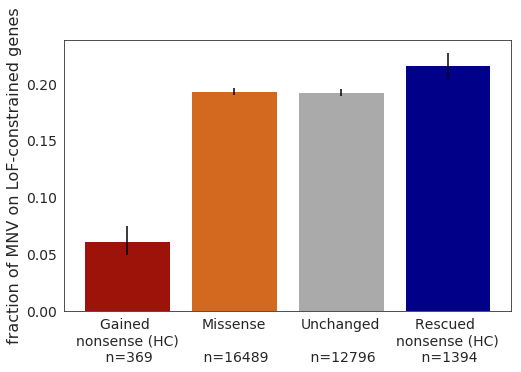

In [23]:
#fig2c:
x = [1,2,3,4]
plt.figure(figsize=(8,5))
plt.rc('axes', axisbelow=True)
plt.grid(axis='None')
plt.bar(x, fracs, yerr=errs,color=["#9D1309FF","#D2691Eff","#aaaaaaff","#000088ff"])
plt.xticks(x, ["Gained \nnonsense (HC)\n n={0}".format(len(oe_g)),"Missense\n\n n={0}".format(len(oe_m)),
               "Unchanged\n\n n={0}".format(len(oe_un)),"Rescued \nnonsense (HC)\n n={0}".format(len(oe_rr))], fontname="Microsoft Sans Serif", rotation=0, size=14)
plt.yticks(fontname = "Microsoft Sans Serif", size=14)
plt.ylabel("fraction of MNV on LoF-constrained genes", fontname="Microsoft Sans Serif", size=16)
plt.show()

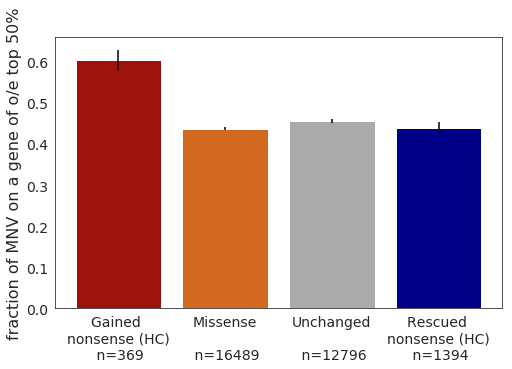

In [24]:
#supplementary fig 2a:
hp_g = sum(oe_g>0.5) / len(oe_g) #unconstrained 50%
hp_rr = sum(oe_rr>0.5) / len(oe_rr)
hp_un = sum(oe_un>0.5) / len(oe_un)
hp_m = sum(oe_m>0.5) / len(oe_m)
fracs = np.array([hp_g, hp_m,hp_un, hp_rr])
ns = np.array([len(oe_g),len(oe_m),len(oe_un),len(oe_rr)])
errs = np.sqrt((fracs*(1-fracs)) /ns)
x = [1,2,3,4]
plt.figure(figsize=(8,5))
plt.grid(axis='None')
plt.bar(x, fracs, yerr=errs,color=["#9D1309FF","#D2691Eff","#aaaaaaff","#000088ff"])
plt.xticks(x, ["Gained \nnonsense (HC)\n n={0}".format(len(oe_g)),"Missense\n\n n={0}".format(len(oe_m)),
               "Unchanged\n\n n={0}".format(len(oe_un)),"Rescued \nnonsense (HC)\n n={0}".format(len(oe_rr))], fontname="Microsoft Sans Serif", rotation=0, size=14)
plt.yticks(fontname = "Microsoft Sans Serif", size=14)
plt.ylabel("fraction of MNV on a gene of o/e top 50%", fontname="Microsoft Sans Serif", size=16)
plt.show()


Instead of binary thresholding, we can actually look at the gradient of MNV category fraction as a function of LOEUF decile:
(Sup.fig 2b)

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Microsoft Sans Serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 648x360 with 0 Axes>

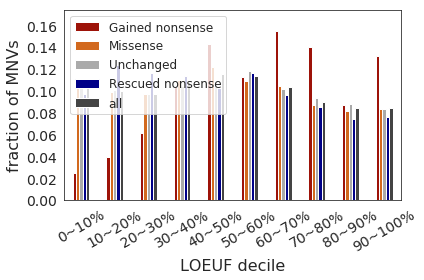

<Figure size 648x360 with 0 Axes>

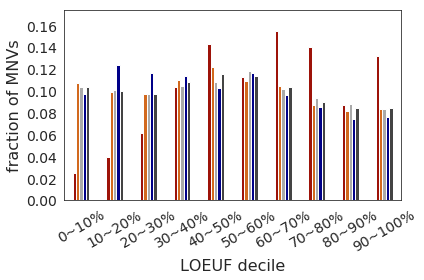

In [25]:
#per decile:
import numpy as np
oe_g_cnt = oe_g.apply(lambda x: np.ceil(x*10)/10).value_counts().sort_index() 
fracs = pd.DataFrame(oe_g_cnt / sum(oe_g_cnt))
errs = pd.DataFrame(np.sqrt((fracs*(1-fracs)) /sum(oe_g_cnt)))
fracs.columns = ["gained_nonsense"]
errs.columns = ["gained_nonsense"]
oe_rr_cnt = oe_rr.apply(lambda x: np.ceil(x*10)/10).value_counts().sort_index() 
fracs["Rescued nonsense"] = pd.DataFrame(oe_rr_cnt / sum(oe_rr_cnt))
errs["Rescued nonsense"] = pd.DataFrame(np.sqrt((fracs["Rescued nonsense"]*(1-fracs["Rescued nonsense"])) /sum(oe_rr_cnt)))
oe_un_cnt = oe_un.apply(lambda x: np.ceil(x*10)/10).value_counts().sort_index() 
fracs["Unchanged"] = pd.DataFrame(oe_un_cnt / sum(oe_un_cnt))
errs["Unchanged"] = pd.DataFrame(np.sqrt((fracs["Unchanged"]*(1-fracs["Unchanged"])) /sum(oe_un_cnt)))
oe_m_cnt = oe_m.apply(lambda x: np.ceil(x*10)/10).value_counts().sort_index() 
fracs["missense"] = pd.DataFrame(oe_m_cnt / sum(oe_m_cnt))
errs["missense"] = pd.DataFrame(np.sqrt((fracs["missense"]*(1-fracs["missense"])) /sum(oe_m_cnt)))
oe_all_cnt = oe_all.apply(lambda x: np.ceil(x*10)/10).value_counts().sort_index() 
fracs["all"] = pd.DataFrame(oe_all_cnt / sum(oe_all_cnt))
errs["all"] = pd.DataFrame(np.sqrt((fracs["all"]*(1-fracs["all"])) /sum(oe_all_cnt)))

fracs.columns = fracs.columns.str.replace("PTV","nonsense")
fracs.columns = fracs.columns.str.replace("gained","Gained")
fracs.columns = fracs.columns.str.replace("missense","Missense")
fracs.columns = fracs.columns.str.replace("_"," ")
xtick = []
for i in (np.arange(10)):
    xtick.append(str(i*10)+"~"+str((i+1)*10)+"%")
plt.figure(figsize=(9,5))
fracs.iloc[:,[0,3,2,1,4]].plot.bar(color=["#9D1309FF","#D2691Eff","#aaaaaaff","#000088ff","#444444ff"])
plt.legend(loc="upper left",prop={'family':"Microsoft Sans Serif", "size":12}, facecolor="#ffffffff")
plt.rc('axes', axisbelow=True)
plt.grid(axis='None')
plt.xticks(np.arange(10),xtick,fontname="Microsoft Sans Serif", size=14, rotation=30)
plt.yticks(fontname = "Microsoft Sans Serif", size=14)
plt.ylabel("fraction of MNVs", fontname="Microsoft Sans Serif", size=16)
plt.xlabel("LOEUF decile", fontname="Microsoft Sans Serif", size=16)
plt.ylim([0,0.174])
plt.tight_layout()
plt.show()

#another one with legends off, for clarity
plt.figure(figsize=(9,5))
fracs.iloc[:,[0,3,2,1,4]].plot.bar(color=["#9D1309FF","#D2691Eff","#aaaaaaff","#000088ff","#444444ff"], legend=None)
#plt.legend(loc="upper left",prop={'family':"Microsoft Sans Serif", "size":12}, facecolor="#ffffffff")
plt.rc('axes', axisbelow=True)
plt.grid(axis='None')
plt.xticks(np.arange(10),xtick,fontname="Microsoft Sans Serif", size=14, rotation=30)
plt.yticks(fontname = "Microsoft Sans Serif", size=14)
plt.ylabel("fraction of MNVs", fontname="Microsoft Sans Serif", size=16)
plt.xlabel("LOEUF decile", fontname="Microsoft Sans Serif", size=16)
plt.ylim([0,0.174])
plt.tight_layout()
plt.show()


## comparison with cell essentiality 
We have also explored how the result is consitent with experimental results (of measuring gene essentiality):
The data for cell essentiality is originally taken from [Hart Lab](http://hart-lab.org/)

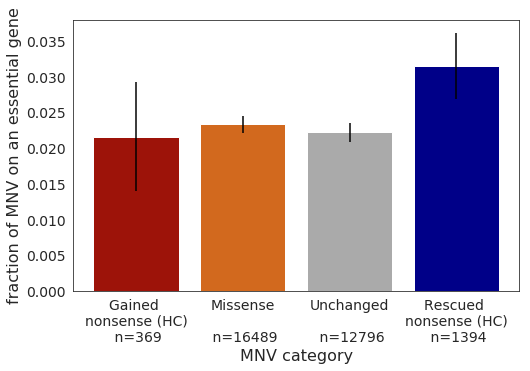

In [26]:
#cell essentiality
def get_trid(genename, table=oe_table):
    l = table[table.gene==genename]
    if l.shape[0]==0: return (np.nan) #for flag
    else: return l.transcript.values[0]

with hl.hadoop_open("gs://gnomad-qingbowang/github_notebooks/TableS2.txt","r") as f:
    core_ess = pd.read_csv(f,sep="\t", header=None)
with hl.hadoop_open("gs://gnomad-qingbowang/github_notebooks/NEGv1.txt","r") as f:
    core_non_ess = pd.read_csv(f,sep="\t", header=None)
core_ess_tr = core_ess.iloc[:,0].apply(lambda x: get_trid(x))
core_non_ess_tr = core_non_ess.iloc[:,0].apply(lambda x: get_trid(x))

g_core_ess = g.apply(lambda x: x in np.array(core_ess_tr)) 
rr_core_ess = rr.apply(lambda x: x in np.array(core_ess_tr)) 
un_core_ess = un.apply(lambda x: x in np.array(core_ess_tr)) 
m_core_ess = m.apply(lambda x: x in np.array(core_ess_tr)) 
all_core_ess = alls.apply(lambda x: x in np.array(core_ess_tr)) #takes time
fracs2 = np.array([sum(g_core_ess)/len(g_core_ess), sum(m_core_ess)/len(m_core_ess),
                  sum(un_core_ess)/len(un_core_ess), sum(rr_core_ess)/len(rr_core_ess)])
ns = np.array([len(g_core_ess),len(m_core_ess),len(un_core_ess),len(rr_core_ess)])
errs = np.sqrt((fracs2*(1-fracs2)) /ns)
x = [1,2,3,4]
plt.figure(figsize=(8,5))
plt.rc('axes', axisbelow=True)
plt.rcParams['figure.facecolor'] = "1"
plt.grid(axis='None')
plt.bar(x, fracs2, yerr=errs,color=["#9D1309FF","#D2691Eff","#aaaaaaff","#000088ff"])
plt.xticks(x, ["Gained \nnonsense (HC)\n n={0}".format(len(oe_g)),"Missense\n\n n={0}".format(len(oe_m)),
               "Unchanged\n\n n={0}".format(len(oe_un)),"Rescued \nnonsense (HC)\n n={0}".format(len(oe_rr))], fontname="Microsoft Sans Serif", rotation=0, size=14)
plt.yticks(fontname = "Microsoft Sans Serif", size=14)
plt.ylabel("fraction of MNV on an essential gene", fontname="Microsoft Sans Serif", size=16)
plt.xlabel("MNV category", fontname="Microsoft Sans Serif", size=16)
plt.show()



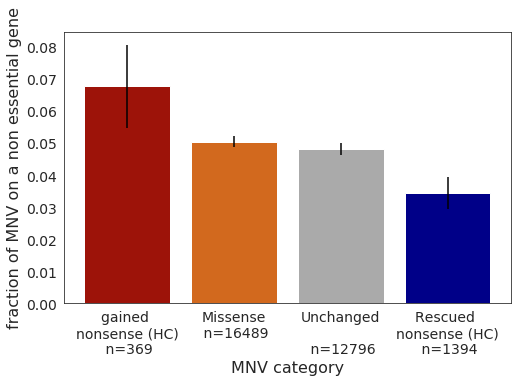

In [27]:
#for non-essential genes:
g_core_non_ess = g.apply(lambda x: x in np.array(core_non_ess_tr)) #OK only 1 there is
rr_core_non_ess = rr.apply(lambda x: x in np.array(core_non_ess_tr)) #OK only 1 there is
un_core_non_ess = un.apply(lambda x: x in np.array(core_non_ess_tr)) #OK only 1 there is
m_core_non_ess = m.apply(lambda x: x in np.array(core_non_ess_tr)) #OK only 1 there is
all_core_non_ess = alls.apply(lambda x: x in np.array(core_non_ess_tr)) #OK only 1 there is
fracs2 = np.array([sum(g_core_non_ess)/len(g_core_non_ess), sum(m_core_non_ess)/len(m_core_non_ess),
                  sum(un_core_non_ess)/len(un_core_non_ess), sum(rr_core_non_ess)/len(rr_core_non_ess)])

ns = np.array([len(g_core_non_ess),len(m_core_non_ess),len(un_core_non_ess),len(rr_core_non_ess)])
errs = np.sqrt((fracs2*(1-fracs2)) /ns)
x = [1,2,3,4]
plt.figure(figsize=(8,5))
plt.rc('axes', axisbelow=True)
plt.rcParams['figure.facecolor'] = "1"
plt.grid(axis='None')
plt.bar(x, fracs2, yerr=errs,color=["#9D1309FF","#D2691Eff","#aaaaaaff","#000088ff"])
plt.xticks(x, ["gained \nnonsense (HC)\n n={0}".format(len(oe_g)),"Missense\n n={0}".format(len(oe_m)),
               "Unchanged\n\n n={0}".format(len(oe_un)),"Rescued \nnonsense (HC)\n n={0}".format(len(oe_rr))], fontname="Microsoft Sans Serif", rotation=0, size=14)
plt.yticks(fontname = "Microsoft Sans Serif", size=14)
plt.ylabel("fraction of MNV on a non essential gene", fontname="Microsoft Sans Serif", size=16)
plt.xlabel("MNV category", fontname="Microsoft Sans Serif", size=16)
plt.show()


## statistical test (fisher test)

Finally, we used fisher test to explore the statistical significance of these differences we observed:

In [29]:
from scipy import stats
def fisher_OR_and_pval(x1, x2, y1, y2): #1 case, 1 alt, 2 case, 2 alt
    oddsratio, pvalue = stats.fisher_exact([[x1, x2], [y1, y2]])
    return (oddsratio, pvalue)
#for the human constraint, 
#(We will impute the NAs with the fraction of OE<0.2 equal to the overall fraction, 
#since simply removing them could introduce one-sided bias to the statistic.
#In other words, we take conservative approach of testing the null hypothesis that 
#"there are no difference in the fraction between two categories, and also between NAs and non-NAs"
#And we don't apply this for CRISPR case, since there are hardly any NAs.

#gained, constrained genes
frac_all = sum(oe_all<0.2) / sum(~np.isnan(oe_all)) 
(x1,x2) = (sum(oe_g<0.2)*(1+frac_all), len(oe_g))
(y1,y2) = (sum(oe_all<0.2)*(1+frac_all) -x1, len(oe_all)-x2) #all other than HC rescue
(OR, pval) = fisher_OR_and_pval(x1, x2, y1, y2)
print ("gained, constrained genes, p-val: {0}".format(pval))

#rescued, constrained genes
frac_all = sum(oe_all<0.2) / sum(~np.isnan(oe_all)) 
(x1,x2) = (sum(oe_rr<0.2)*(1+frac_all), len(oe_rr))
(y1,y2) = (sum(oe_all<0.2)*(1+frac_all) -x1, len(oe_all)-x2) #all other than HC rescue
(OR, pval) = fisher_OR_and_pval(x1, x2, y1, y2)
print ("rescued, constrained genes, p-val: {0}".format(pval))

#gained, unconstrained genes
frac_all = sum(oe_all>0.5) / sum(~np.isnan(oe_all)) 
(x1,x2) = (sum(oe_g>0.5)*(1+frac_all), len(oe_g))
(y1,y2) = (sum(oe_all>0.5)*(1+frac_all) -x1, len(oe_all)-x2) #all other than HC rescue
(OR, pval) = fisher_OR_and_pval(x1, x2, y1, y2)
print ("gained, unconstrained genes, p-val: {0}".format(pval))

#rescued, unconstrained genes(non sig)
frac_all = sum(oe_all>0.5) / sum(~np.isnan(oe_all)) 
(x1,x2) = (sum(oe_rr>0.5)*(1+frac_all), len(oe_rr))
(y1,y2) = (sum(oe_all>0.5)*(1+frac_all) -x1, len(oe_all)-x2) #all other than HC rescue
(OR, pval) = fisher_OR_and_pval(x1, x2, y1, y2)
print ("rescued, unconstrained genes, p-val: {0}".format(pval))

#rescued, core essential
(x1,x2) = (sum(rr_core_ess), len(rr_core_ess))
(y1,y2) = (sum(all_core_ess) -x1, len(all_core_ess)-x2)
(OR, pval) = fisher_OR_and_pval(x1, x2, y1, y2)
print ("rescued, CRISPR essential genes, p-val: {0}".format(pval))

#gained, core essential (non sig)
(x1,x2) = (sum(g_core_non_ess), len(g_core_non_ess))
(y1,y2) = (sum(all_core_non_ess) -x1, len(all_core_non_ess)-x2) 
(OR, pval) = fisher_OR_and_pval(x1, x2, y1, y2)
print ("gained, CRIPSR essential genes, p-val: {0}".format(pval))

#gained, core non essential(non sig)
(x1,x2) = (sum(g_core_non_ess), len(g_core_non_ess))
(y1,y2) = (sum(all_core_non_ess) -x1, len(all_core_non_ess)-x2) 
(OR, pval) = fisher_OR_and_pval(x1, x2, y1, y2)
print ("gained, CRIPSR non-essential genes, p-val: {0}".format(pval))

#rescued, core non essential
(x1,x2) = (sum(rr_core_non_ess), len(rr_core_non_ess))
(y1,y2) = (sum(all_core_non_ess) -x1, len(all_core_non_ess)-x2)
(OR, pval) = fisher_OR_and_pval(x1, x2, y1, y2)
print ("rescued, CRIPSR non-essential genes, p-val: {0}".format(pval))

gained, constrained genes, p-val: 1.4033440383174333e-11
rescued, constrained genes, p-val: 0.03897486996043722
gained, unconstrained genes, p-val: 7.036968775681469e-05
rescued, unconstrained genes, p-val: 0.6788121390564654
rescued, CRISPR essential genes, p-val: 0.046533749188893914
gained, CRIPSR essential genes, p-val: 0.1169346144535869
gained, CRIPSR non-essential genes, p-val: 0.1169346144535869
rescued, CRIPSR non-essential genes, p-val: 0.01261215232173633


## End notes

- This tutorial explained how to explore the functional impact of MNV in the general population. 
- The per-sample statistics (number of MNV per sample per category) is not shown here for it is not public, but users can easily do it with their own data by stratifying by the sample and doing the equivalent analysis